In [34]:
# !pip install rasterio geopandas folium shapely ipywidgets ipyleaflet


Full disclosure I asked ChatGPT to help me with the reprojecting and file type conversions because I can never remember the syntax and I'm in a rush

In [35]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.enums import Resampling
# Load the raster image with rasterio
raster_path = 'camera1_downscale.tif'  
dst_raster_path = 'camera1_downscale_4326.tif'  
dst_png_path = 'camera1_downscale_4326.png'  


# Define the target CRS
dst_crs = 'EPSG:4326'

# Open the source raster
with rasterio.open(raster_path) as src:
    # Calculate the transform, width, and height for the new projection
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    # Update the metadata with the new projection info
    dst_meta = src.meta.copy()
    dst_meta.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Reproject and save the new raster
    with rasterio.open(dst_raster_path, 'w', **dst_meta) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )



In [36]:
from osgeo import gdal
import numpy as np
from PIL import Image

# # Open the GeoTIFF dataset
dataset = gdal.Open(dst_raster_path)

# This works if you don't mind the black band around the image

# # Get the PNG driver
# png_driver = gdal.GetDriverByName('PNG')

# # Use CreateCopy to save the dataset as a PNG
# png_driver.CreateCopy(dst_png_path, dataset, 0)

# # Close the datasets
# dataset = None

# .... but I was a perfectionist and wanted that masked out. 

# Get the dimensions of the raster
width = dataset.RasterXSize
height = dataset.RasterYSize

# Read RGB bands
r_band = dataset.GetRasterBand(1).ReadAsArray()
g_band = dataset.GetRasterBand(2).ReadAsArray()
b_band = dataset.GetRasterBand(3).ReadAsArray()

# Create a new array for the alpha channel (transparency)
alpha_band = np.ones((height, width), dtype=np.uint8) * 255  # Fully opaque by default

# Set the alpha channel to 0 (transparent) where RGB is (0, 0, 0)
alpha_band[(r_band == 0) & (g_band == 0) & (b_band == 0)] = 0

# Create a new PNG dataset with an RGBA structure
# First, create an intermediate dataset to hold RGB and Alpha
intermediate_driver = gdal.GetDriverByName('MEM')
intermediate_dataset = intermediate_driver.Create('', width, height, 4, gdal.GDT_Byte)

# Write RGB data
intermediate_dataset.GetRasterBand(1).WriteArray(r_band)  # Red
intermediate_dataset.GetRasterBand(2).WriteArray(g_band)  # Green
intermediate_dataset.GetRasterBand(3).WriteArray(b_band)  # Blue
intermediate_dataset.GetRasterBand(4).WriteArray(alpha_band)  # Alpha

# Use CreateCopy to save the intermediate dataset as a PNG
png_driver = gdal.GetDriverByName('PNG')
png_driver.CreateCopy(dst_png_path, intermediate_dataset, 0)

# Clean up
intermediate_dataset = None
dataset = None

In [37]:
# If your "bounds" aren't in lat/long Folium will be sad
# with rasterio.open(dst_raster_path) as src:
#   bounds = src.bounds
#   print(bounds)
#   # Get the image bounds and center
#   center = [(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2]


EPSG:4326



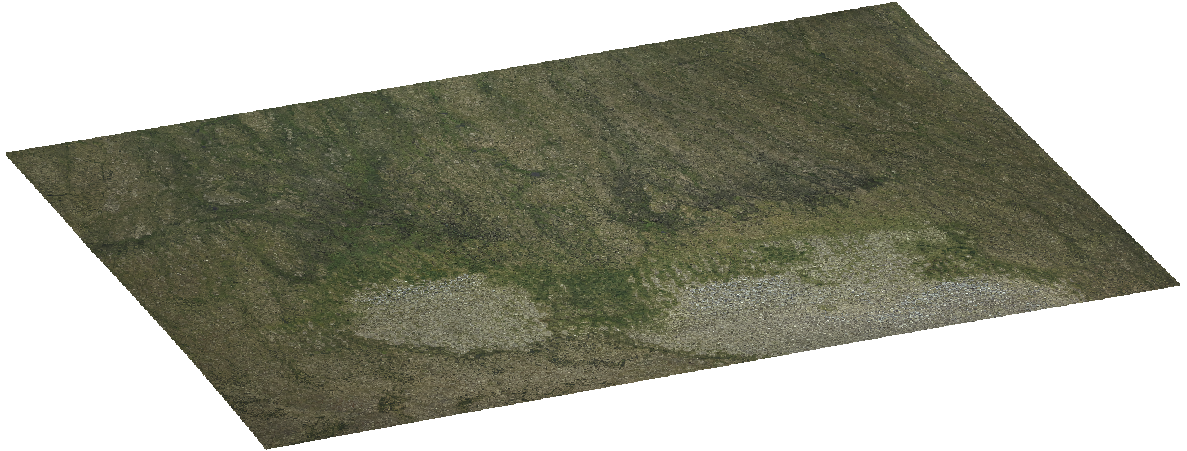

In [38]:
import rasterio
import folium
import geopandas as gpd
from folium.plugins import Draw
from shapely.geometry import shape
import json

with rasterio.open(dst_raster_path) as src:
  print(src.crs)
  bounds = src.bounds
  # Get the image bounds and center
  center = [(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2]

# Create a folium map centered around the raster image location
m = folium.Map(location=center, zoom_start=14)

# Add raster image to the map
image_layer = folium.raster_layers.ImageOverlay(
    name='Raster Image',
    image=dst_png_path,  # Path to the image
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    # opacity=0.6,
)
image_layer.add_to(m)

# Add drawing tools to the map
draw = Draw(export=True)
draw.add_to(m)

# Display the map with raster image and drawing tools
m


Right now the popup sends you to your local files instead of, say, the cluster if you're running on there. But that's maybe a small price to pay?

Or hack the JavaScript and divine the secrets [here](https://github.com/python-visualization/folium/issues/1388)